### contrast (대비 or 명암)

    - contrast는 물체를 식별할 수 있도록 하는 휘도(luminance) 또는 색(color)의 차이

<img src="img/contrast.jpg" alt='contrast' width="40%" height="40%">

### dynamic range (동적 범위)
     이미지의 maximum contrast를 dynamic range라고 함
     카메라는 재현할 수 있는 dynamic range에 한계가 있음
     → 명암의 대비가 큰 장면을 눈으로 볼 때와 사진으로 볼 때 차이가 존재

### low contrast vs high contrast
    contrast가 낮으면 물체 간의 구분력이 떨어짐
<img src="img/low_high_contrast.png" alt='low_high_contrast' width="50%" height="50%">

    - HDR (High Dynamic Range)
        순간적으로 노출이 다른 장면을 촬영하여 밝은 곳과 어두운 곳이 모두 잘보이게끔 합성하는 이미지 후처리 방식
<img src="img/hdr.jpg" alt='hdr' width="50%" height="50%">

### 코드 실습

#### 1. check contrast

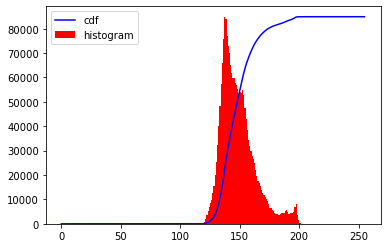

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('landscape.jpg')

# 히스토그램 생성
hist, bins = np.histogram(img, 256, [0, 256])
# 정규화된 누적 히스토그램 생성
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

plt.plot(cdf_normalized, color='b')
plt.hist(img.flatten(), 256, [0,256], color='r')
plt.legend(['cdf', 'histogram'], loc='upper left')
plt.show()

cv2.imshow('image', img)
cv2.waitKey()
cv2.destroyAllWindows()

#### 2. Min-Max stretching

가장 작은 값을 0, 가장 큰 값을 255로 매핑
Xnew = (X - X.min) / (X.max - X.min) x 255

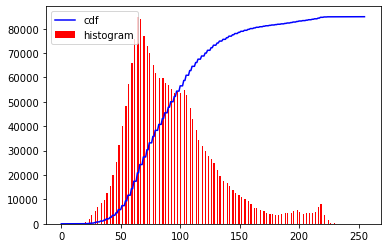

In [23]:
img = cv2.imread('landscape.jpg')

# print(img)
img_minmax = (img - img.min()) / (img.max() - img.min()) * 255.0
img_minmax = img_minmax.astype(np.uint8)

hist, bins = np.histogram(img_minmax, 256, [0, 256])
cdf = hist.cumsum()

cdf_normalized = cdf * hist.max() / cdf.max()

plt.plot(cdf_normalized, color='b')
plt.hist(img_minmax.flatten(), 256, [0,256], color='r')
plt.legend(['cdf', 'histogram'], loc='upper left')
plt.show()

cv2.imshow('image', img)
cv2.waitKey()
cv2.destroyAllWindows()

### 과제
#### 3. Percentile stretching

히스토그램의 꼬리 끝에서 데이터의 일정 비율을 잘라냄

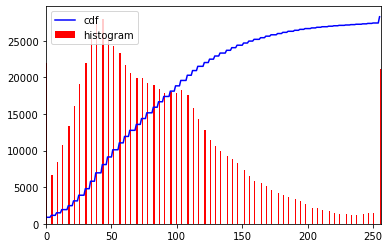

In [32]:
'''
    percentile stretching 함수

    Parameters
    ----------
    p_low: int (0~100)
        percentile stretching을 수행하기 위한 하위 백분율
    p_high: int (0~100)
        percentile stretching을 수행하기 위한 상위 백분율

    Returns
    -------
    img_ptile: array
        percentile stretching 처리된 이미지 배열

'''
def percentile_stretching(img, p_low, p_high) :
    hist, bins = np.histogram(img, 256, [0,256])
    size = img.size
    cnt=0

    low_limit = size * p_low / 100.0
    for i in range(0,256) :
        cnt += hist[i]
        if cnt > low_limit:
            low = bins[i]
            break

    cnt=0
    high_limit = size * p_high / 100.0
    for i in range(0,256) :
        cnt += hist[i]
        if cnt > high_limit:
            high = bins[i]
            break

    img_ptile = np.zeros((img.shape[0], img.shape[1]))

    for i in range(img.shape[0]) :
        for j in range(img.shape[1]) :
            if img[i][j] < low:
                img_ptile[i][j] = 0
            elif img[i][j] > high:
                img_ptile[i][j] = 255
            else :
                img_ptile[i][j] = ((img[i][j] - low) / (high - low)) * 255.0

    img_ptile = img_ptile.astype(np.uint8)

    return img_ptile


img = cv2.imread('landscape.jpg', 0)

img_percentile = percentile_stretching(img, 3, 97)

hist, bins = np.histogram(img_percentile, 256, [0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

# 히스토그램 시각화하기
plt.plot(cdf_normalized, color='b')
plt.hist(img_percentile.flatten(), 256, [0,256], color='r')
plt.xlim([0, 256])
plt.legend(['cdf', 'histogram'], loc='upper left')
plt.show()

cv2.imshow('image', img_percentile)
cv2.waitKey()

cv2.destroyAllWindows()

과제
방법 1: numpy 함수를 사용한 방법

In [28]:
def percentile_stretching(img, p_low, p_high) :
    o_min = np.percentile(img, p_low)
    o_max = np.percentile(img, p_high)

    img_ptile = (img - o_min) / float(o_max - o_min) * 255.0    # min,max값을 기준으로 0~255 값으로 정규화
    img_ptile = np.clip(img_ptile, 0, 255) # 영상의 화소값을 0~255 범위로 맞춤 (0보다 작으면 0으로, 255보다 크면 255로)

    img_ptile = img_ptile.astype('uint8')  # 현재 img_tile 배열의 데이터 타입이 float이므로 uint8로 변환해 줌

    return img_ptile


과제
방법 2: 상한가, 하한가 계산

In [30]:
def percentile_stretching(img, p_low, p_high) :
    hist, _ = np.histogram(img, 256, [0,256]) # 리턴값 중 bins는 사용하지 않음
    cdf = hist.cumsum()

    # p_low 및 p_high 백분위에 해당하는 누적 히스토그램 값 계산
    hist_low = cdf[-1]/100*p_low    # 누적 히스토그램의 마지막 열 값 == 영상의 전체 픽셀 개수
    hist_high = cdf[-1]/100*p_high

    # 히스토그램에서 하한에 해당하는 화소값 탐색
    o_min = 255
    for i in range(256):
        if cdf[i] > hist_low:
            o_min = i
            break

    # 히스토그램에서 상한에 해당하는 화소값 탐색
    o_max = 0
    for i in range(255,-1,-1): # 255부터 0까지 역순으로 순회
        if cdf[i] < hist_high:
            o_max = i+1
            break

    # min,max값을 기준으로 0~255 값으로 정규화 (img 배열의 overflow 발생을 방지하기 위해 데이터 타입을 float으로 변환)
    img_ptile = (img.astype('float32') - o_min) / (o_max - o_min) * 255.0

    # 영상의 화소값을 0~255 범위로 맞춤 (0보다 작으면 0으로, 255보다 크면 255로)
    img_ptile[img_ptile < 0] = 0
    img_ptile[img_ptile > 255] = 255.0

    img_ptile = img_ptile.astype('uint8')  # 현재 img_tile 배열의 데이터 타입이 float이므로 uint8로 변환해 줌

    return img_ptile

#### 4. Histogram equalization

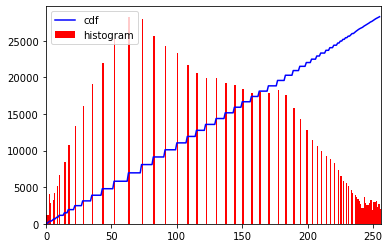

In [37]:
img = cv2.imread('landscape.jpg')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
equalized = cv2.equalizeHist(gray)
img_equalized = cv2.merge([equalized, equalized, equalized]) # RGB로 병합

hist, bins = np.histogram(equalized, 256, [0, 256])

# 정규화된 누적 히스토그램 생성하기
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

plt.plot(cdf_normalized, color='b')
plt.hist(equalized.flatten(), 256, [0,256], color='r')
plt.xlim([0,256])
plt.legend(['cdf', 'histogram'], loc='upper left')
plt.show()

cv2.imshow('image', equalized)
cv2.waitKey()

cv2.destroyAllWindows()